In [2]:
# PARTE RAQUEL

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, f1_score
from cleanlab.filter import find_label_issues
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd # For .shp and .geoJSON files

In [62]:
folder = ''
df = pd.read_csv(folder+'AllData.csv', index_col='CVEGEO')
df_id = df[['NOM_ENT','NOM_MUN']].copy()
df = df.drop(columns=['NOM_ENT','NOM_MUN'])
print(len(df))
df.head()

2469


,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo


In [46]:
#Defining function for plotting

def viz_on_map(df, alpha_col = None, color_col = 'semaforo', color_map = {
    'Rojo': 'red',
    'Amarillo': 'gold',
    'Verde': 'green'},
    title ='Water Quality Indicator by Municipality with Confidence-Based Transparency'):
    ''' This function makes a previev of the column 'semaforo' on the map of Mexico '''

    municipios_path = 'mun22gw/mun22gw.shp'
    municipios = gpd.read_file(municipios_path)
    municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
    mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
    if alpha_col:
        columns_to_plot = [alpha_col,color_col]
    else:
        columns_to_plot = color_col
    df = mun_geo.merge(df[columns_to_plot], how = 'outer', left_on='CVEGEO', right_index=True)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 10))

    # 1. First plot all geometries with full opacity (for borders)
    df.boundary.plot(ax=ax, color='black', linewidth=0.2)

    # 2. Create a new column for plotting colors
    df['plot_color'] = df[color_col].map(color_map).fillna('gray')

    # 3. Plot with confidence-based alpha
    for class_name in color_map.keys():
        # Filter features for this class
        class_data = df[df[color_col] == class_name]
        if not class_data.empty:
            # Plot with variable alpha
            if alpha_col is not None:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    alpha=class_data[alpha_col].fillna(0),  # Use confidence for alpha
                    edgecolor='none',
                    label=class_name)
            else:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    edgecolor='none',
                    label=class_name)

    # 4. Create custom legend
    legend_elements = []
    for class_name, color in color_map.items():
        legend_elements.append(mpatches.Patch(
            color=color,
            label=class_name,
            alpha=1.0
        ))
    
    if alpha_col is not None:
        # Add confidence explanation
        confidence_elements = [
            mpatches.Patch(color='black', alpha=0.3, label='Low Confidence (85%)'),
            mpatches.Patch(color='black', alpha=0.6, label='Medium Confidence (90%)'),
            mpatches.Patch(color='black', alpha=0.9, label='High Confidence (99%)')
            ]
        ax.legend(
            handles=legend_elements + confidence_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
    )
    else:
        ax.legend(
            handles=legend_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
        )
        title ='Water Quality Indicator by Municipality'

    plt.title(title)
    plt.tight_layout()
    plt.show()

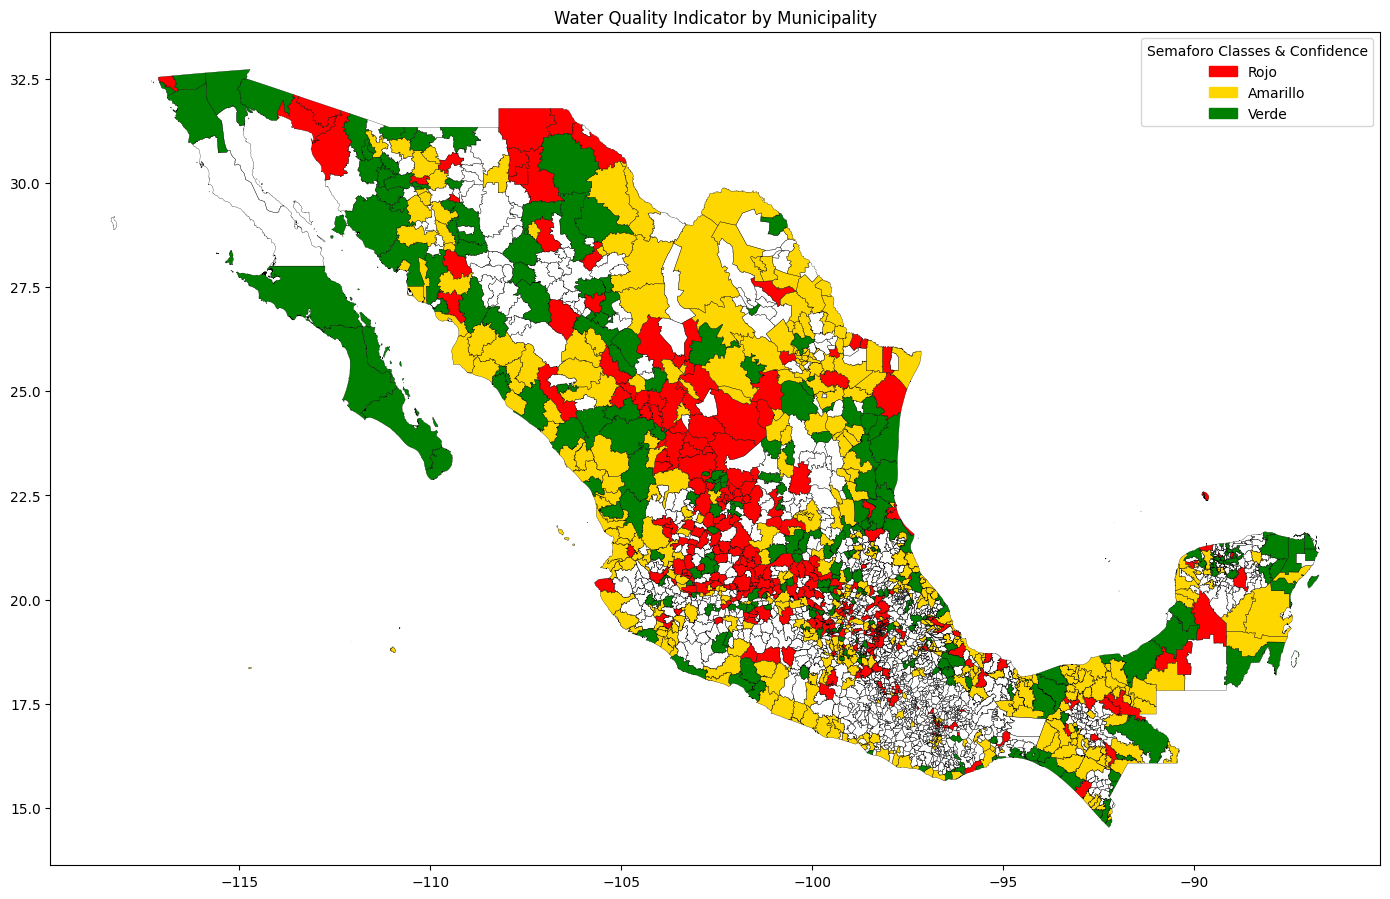

In [47]:
viz_on_map(df)

In [6]:
X_data = df.drop('semaforo',axis = 1)
y_data = df['semaforo']

In [7]:
print(len(y_data))
print(len(y_data[y_data.isna()]))
print(len(y_data)-len(y_data[y_data.isna()]))

2469
1423
1046


In [ ]:
class RobustMultiModelNaNClassifier:
    def __init__(self, models=None, confidence_threshold=0.60, 
                 prediction_threshold=0.85, max_iterations=25):
        """
        Enhanced classifier that operates directly on 'semaforo' column.
        
        Args:
            models: List of classifier models (odd number recommended)
            confidence_threshold: Threshold for accepting ensemble predictions
            prediction_threshold: Threshold for keeping final predictions
            max_iterations: Maximum number of iterations
        """
        # Default robust models for noisy data
        if models is None:
            self.models = [
                CatBoostClassifier(iterations=500, class_weights={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27}, verbose=0),
                XGBClassifier(scale_pos_weight=2, max_depth=5, reg_alpha=1),
                RandomForestClassifier(max_samples=0.5, class_weight={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27})
            ]
        else:
            if len(models) % 2 == 0:
                raise ValueError("Number of models must be odd for voting")
            self.models = models
            
        self.confidence_threshold = confidence_threshold
        self.prediction_threshold = prediction_threshold
        self.max_iterations = max_iterations
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.fitted_models = []
        
    # def _clean_data(self, X, y):
    #     """Remove outliers and likely mislabeled samples"""
    #     # 1. Remove feature outliers
    #     iso = IsolationForest(contamination='auto', random_state=42)
    #     outliers = iso.fit_predict(X)
    #     clean_mask = outliers == 1
        
    #     # 2. Detect label issues (requires initial model)
    #     temp_model = RandomForestClassifier(max_samples=0.5)
    #     temp_model.fit(X[clean_mask], y[clean_mask])
    #     probas = temp_model.predict_proba(X[clean_mask])
    #     issues = find_label_issues(y[clean_mask], probas)
        
    #     return X[clean_mask][~issues], y[clean_mask][~issues]
    
    def fit(self, X, y):
        """Fit all models on cleaned and scaled training data"""
        # Clean data
        #X_clean, y_clean = self._clean_data(X, y)
        
        # Scale numeric features
        X_scaled = self.scaler.fit_transform(X) #X_clean removed
        
        # Fit models
        self.fitted_models = []
        for model in self.models:
            try:
                model.fit(X_scaled, y) # y_clean removed
            except Exception as e:
                print(f"Error fitting {model.__class__.__name__}: {str(e)}")
                continue
            self.fitted_models.append(model)
    
    def predict_with_confidence(self, X):
        """
        Predict using ensemble of models with confidence.
        Returns predictions and confidence scores.
        """
        X_scaled = self.scaler.transform(X)
        
        all_probs = []
        for model in self.fitted_models:
            try:
                proba = model.predict_proba(X_scaled)
                all_probs.append(proba)
            except Exception as e:
                print(f"Prediction error with {model.__class__.__name__}: {str(e)}")
                continue
                
        if not all_probs:
            raise ValueError("No models produced valid predictions")
        
        # Average probabilities across models
        avg_probs = np.mean(all_probs, axis=0)
        
        # Get predictions and confidence
        predictions = np.argmax(avg_probs, axis=1)
        confidence = np.max(avg_probs, axis=1)
        
        return predictions, confidence
    
    def process_dataframe(self, df):
        """
        Process the dataframe to predict NaN values in 'semaforo' column.
        Returns modified dataframe and iteration count.
        """
        # Validate input
        if 'semaforo' not in df.columns:
            raise ValueError("Dataframe must contain 'semaforo' column")
            
        # Make a working copy (we'll modify the 'semaforo' column directly)
        df_working = df.copy()
        
        # Add confidence column and set known labels to 1.0
        df_working['confidence'] = np.where(
            df_working['semaforo'].notna(), 
            1.0,  # Full confidence for known labels
            np.nan  # NaN for unknown labels
        )
        
        # Encode labels only if there are valid labels
        valid_mask = df_working['semaforo'].notna()
        if valid_mask.sum() == 0:
            raise ValueError("No valid labels found in 'semaforo' column")
        
        self.label_encoder.fit(df_working.loc[valid_mask, 'semaforo'])
        
        # Track which rows have been predicted
        predicted_mask = df_working['semaforo'].isna()
        iteration = 0
        
        while predicted_mask.any() and iteration < self.max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}: {predicted_mask.sum()} NaN values remaining")
            
            # Prepare validation data (non-NaN rows)
            validation_df = df_working[~predicted_mask].copy()
            
            # Stratified split to maintain class balance
            train_df, test_df = train_test_split(
                validation_df, 
                test_size=0.2, 
                random_state=42 + iteration,
                stratify=validation_df['semaforo']
            )
            
            # Prepare features and target
            X_train = train_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_train = self.label_encoder.transform(train_df['semaforo'])
            
            X_test = test_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_test = test_df['semaforo']
            
            # Fit models
            self.fit(X_train, y_train)
            
            # Predict on test set with confidence
            test_pred_encoded, test_conf = self.predict_with_confidence(X_test)
            test_pred = self.label_encoder.inverse_transform(test_pred_encoded)
            
            # Calculate robust metrics
            test_bal_acc = balanced_accuracy_score(y_test, test_pred)
            test_f1 = f1_score(y_test, test_pred, average='weighted')
            avg_confidence = np.mean(test_conf)
            
            print(f"Test Balanced Accuracy: {test_bal_acc:.2f}")
            print(f"Test Weighted F1: {test_f1:.2f}")
            print(f"Avg Confidence: {avg_confidence:.2f}")
            
            # Only proceed if confidence threshold is met
            if avg_confidence < self.confidence_threshold:
                print("Confidence below threshold, stopping iteration")
                continue
                
            # Predict on NaN rows
            X_predict = df_working[predicted_mask].drop(
                columns=['semaforo', 'confidence'], 
                errors='ignore'
            )
            
            if not X_predict.empty:
                pred_encoded, pred_conf = self.predict_with_confidence(X_predict)
                pred_labels = self.label_encoder.inverse_transform(pred_encoded)
                
                # Update only high-confidence predictions
                high_conf_mask = pred_conf >= self.prediction_threshold
                
                if high_conf_mask.any():
                    # Update both the label and confidence
                    df_working.loc[predicted_mask, 'semaforo'] = np.where(
                        high_conf_mask,
                        pred_labels,
                        df_working.loc[predicted_mask, 'semaforo']
                    )
                    df_working.loc[predicted_mask, 'confidence'] = np.where(
                        high_conf_mask,
                        pred_conf,
                        df_working.loc[predicted_mask, 'confidence']
                    )
                
                # Update predicted mask
                predicted_mask = df_working['semaforo'].isna()
            else:
                print("No rows left to predict")
                
        # Final metrics
        num_predicted = (~df_working['semaforo'].isna() & (df_working['confidence'] < 1.0)).sum()
        avg_final_confidence = df_working.loc[df_working['confidence'] < 1.0, 'confidence'].mean()
        
        print(f"\nFinal Results:")
        print(f"- Predicted {num_predicted} values")
        print(f"- Average confidence of predictions: {avg_final_confidence:.2f}")
        
        if num_predicted > 0:
            # For evaluation, compare original known labels with current labels
            original_known_mask = df['semaforo'].notna()
            comparison_mask = original_known_mask & (df['semaforo'] != df_working['semaforo'])
            
            if comparison_mask.any():
                changed_count = comparison_mask.sum()
                change_accuracy = (df['semaforo'][comparison_mask] == df_working['semaforo'][comparison_mask]).mean()
                print(f"- Changed {changed_count} original labels")
                print(f"- Accuracy on changed labels: {change_accuracy:.2f}")
        
        return df_working, iteration

In [9]:
classifier = RobustMultiModelNaNClassifier()
df_modified, iterations = classifier.process_dataframe(df)


Iteration 1: 1423 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.50
Test Weighted F1: 0.52
Avg Confidence: 0.68

Iteration 2: 1218 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.56
Test Weighted F1: 0.58
Avg Confidence: 0.74

Iteration 3: 966 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.69
Test Weighted F1: 0.70
Avg Confidence: 0.79


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Iteration 4: 729 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.73
Test Weighted F1: 0.74
Avg Confidence: 0.83

Iteration 5: 586 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.72
Test Weighted F1: 0.73
Avg Confidence: 0.82

Iteration 6: 475 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.75
Test Weighted F1: 0.75
Avg Confidence: 0.86

Iteration 7: 405 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.74
Test Weighted F1: 0.75
Avg Confidence: 0.84

Iteration 8: 356 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.79
Test Weighted F1: 0.80
Avg Confidence: 0.84

Iteration 9: 322 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.77
Test Weighted F1: 0.77
Avg Confidence: 0.84

Iteration 10: 285 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.84

Iteration 11: 258 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.76
Test Weighted F1: 0.77
Avg Confidence: 0.85

Iteration 12: 234 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.76
Test Weighted F1: 0.76
Avg Confidence: 0.83

Iteration 13: 218 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.84

Iteration 14: 199 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.85

Iteration 15: 185 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.84

Iteration 16: 174 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Balanced Accuracy: 0.82
Test Weighted F1: 0.82
Avg Confidence: 0.84

Iteration 17: 168 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.75
Test Weighted F1: 0.75
Avg Confidence: 0.84

Iteration 18: 160 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.81
Avg Confidence: 0.84

Iteration 19: 147 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.85

Iteration 20: 145 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.76
Test Weighted F1: 0.77
Avg Confidence: 0.85

Iteration 21: 140 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.84

Iteration 22: 134 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.79
Test Weighted F1: 0.80
Avg Confidence: 0.83

Iteration 23: 133 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.76
Test Weighted F1: 0.76
Avg Confidence: 0.83

Iteration 24: 126 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Balanced Accuracy: 0.76
Test Weighted F1: 0.76
Avg Confidence: 0.84

Iteration 25: 118 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:01:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.75
Test Weighted F1: 0.75
Avg Confidence: 0.83

Final Results:
- Predicted 1311 values
- Average confidence of predictions: 0.91


In [10]:
df_modified[df_modified['confidence']!=1]

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,confidence
CVEGEO,,,,,,,,,,,,,,
1006,47646,1912.241007,1.957359e+04,58.23558,6.728276,2,19,2,0.836746,0,6.0,12.722222,Rojo,0.909935
1009,22485,1948.772727,2.296610e+04,55.62216,2.539697,9,18,1,0.871654,0,0.0,1.750000,Rojo,0.882061
1011,61997,1917.725191,1.377702e+04,57.86937,3.391930,9,27,7,0.891635,0,6.0,61.970213,Rojo,0.940153
2006,117568,145.451977,3.409724e+06,48.67578,1.004158,0,27,0,0.358984,47,3.5,2.029412,NaN,NaN
4010,31714,213.374074,1.394607e+06,105.91920,6.762152,0,19,0,0.543774,0,0.0,1.076923,Amarillo,0.877468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32028,2451,1497.860215,4.820085e+04,67.96404,1.511670,3,8,0,0.703315,0,0.0,1.000000,Rojo,0.891435
32031,8683,2082.835979,1.582976e+05,59.60943,1.461982,0,8,2,0.697977,0,6.0,1.100000,Verde,0.944793
32043,1365,2196.666667,1.974781e+04,57.66498,0.558261,2,4,1,0.626921,6,0.0,1.000000,Verde,0.969714


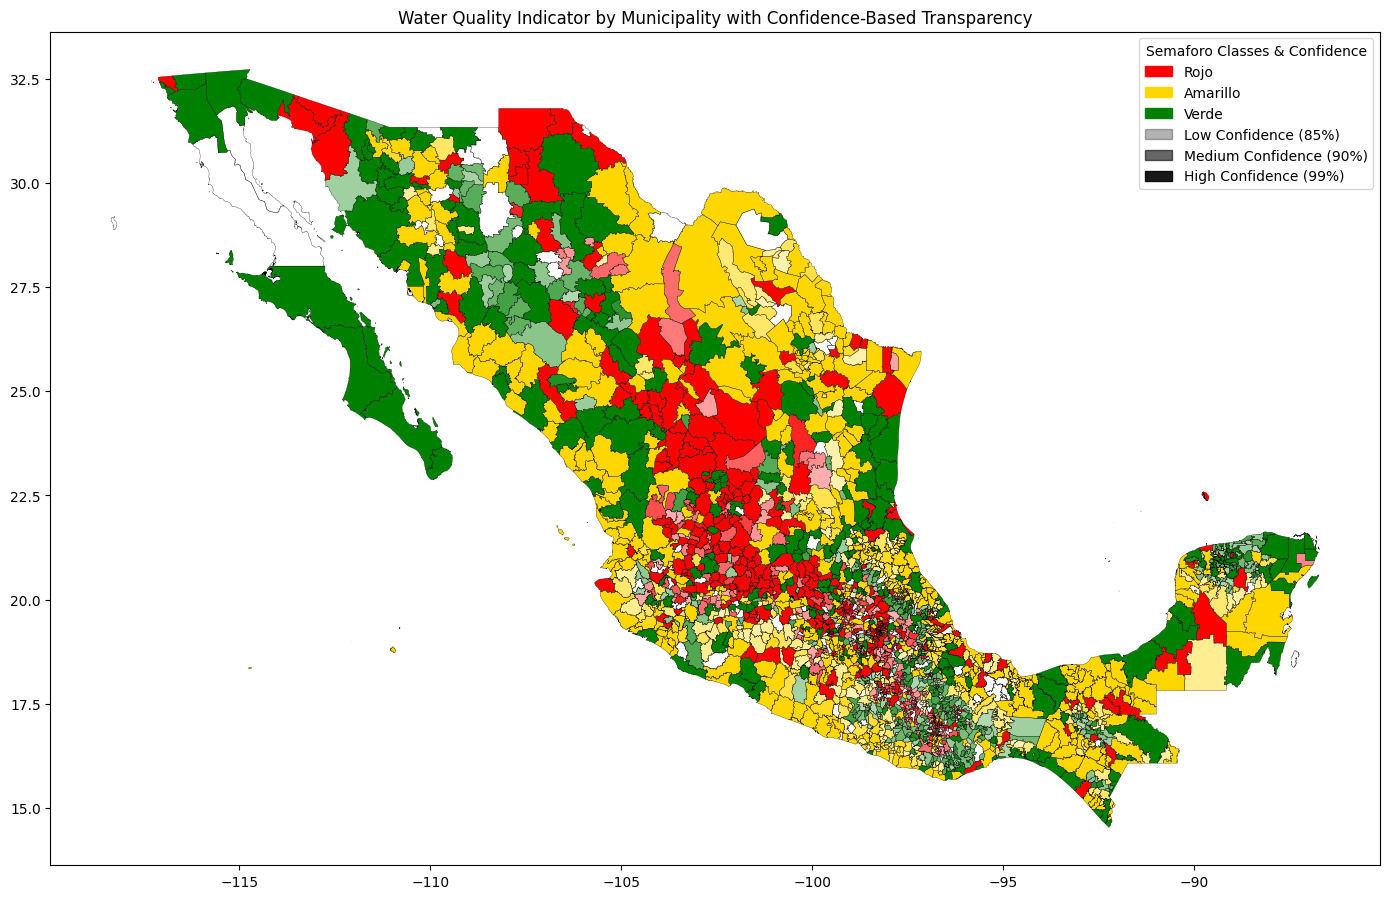

In [38]:
df_modified
# Create alpha from confidence
scaler = MinMaxScaler(feature_range=(0.3, 1.0))
scaled_values = scaler.fit_transform(df_modified[['confidence']])
df_modified['scaled_confidence'] = scaled_values.flatten()
viz_on_map(df_modified, alpha_col='scaled_confidence')

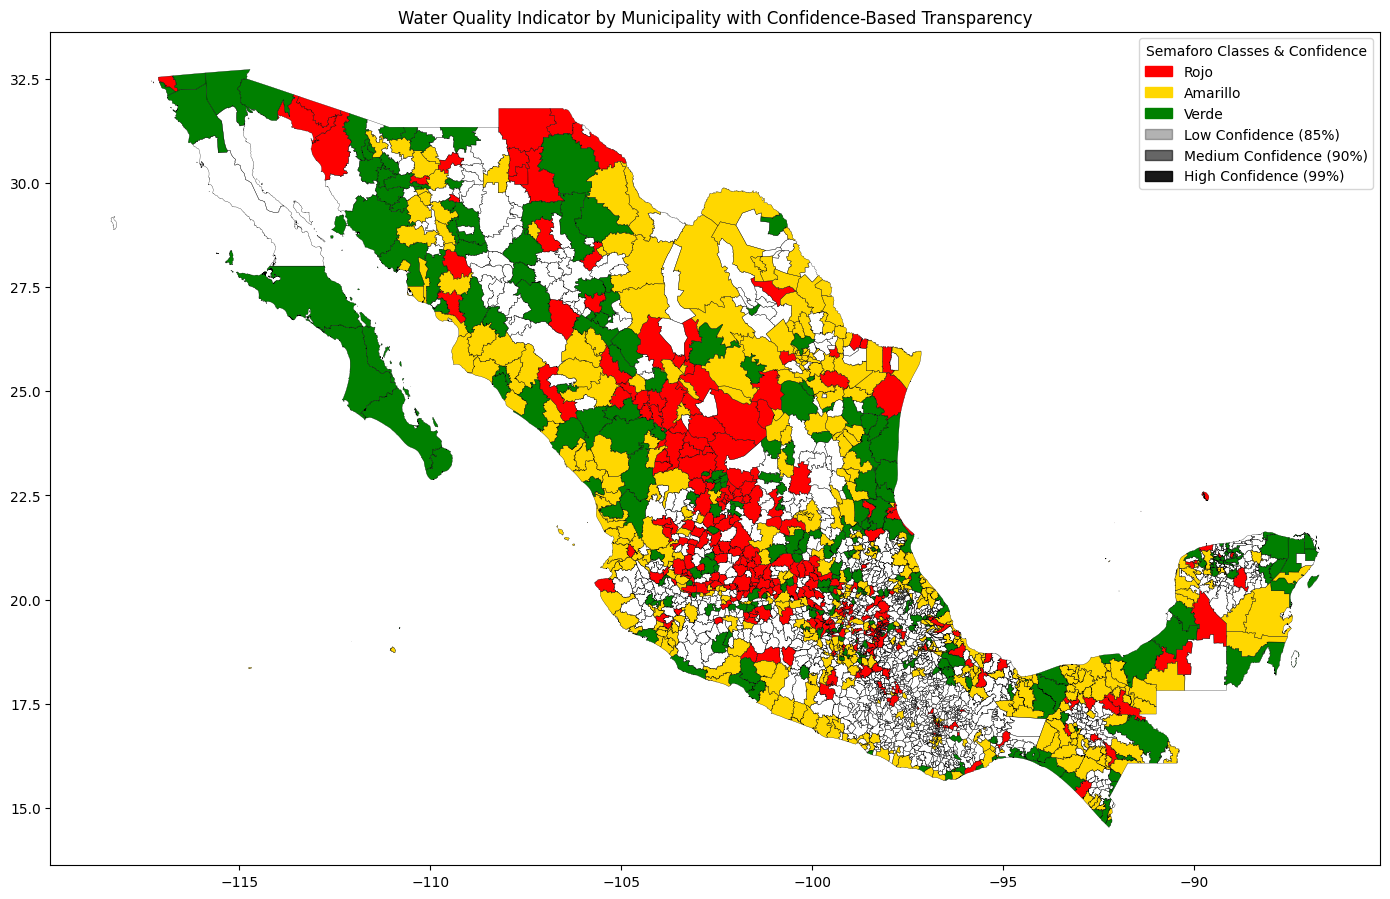

In [39]:
# plot only real (not predicted) labels
real_labels = df_modified[df_modified['confidence']==1]
viz_on_map(real_labels)

In [55]:
df['semaforo'].notna()

CVEGEO
1001      True
1002      True
1003      True
1004      True
1005      True
         ...  
32054     True
32055     True
32056     True
32057     True
32058    False
Name: semaforo, Length: 2469, dtype: bool

In [85]:

from sklearn.model_selection import train_test_split

def create_validation_dataset(df, target_col='semaforo', test_size=0.2, 
                            random_state=22, stratify=True):
    """
    Creates validation dataset using scikit-learn's train_test_split with stratification.
    
    Args:
        df: Input DataFrame or GeoDataFrame
        target_col: Column with values to mask (default 'semaforo')
        test_size: Proportion of values to mask (default 0.2)
        random_state: Random seed for reproducibility
        stratify: Whether to stratify by target_col (default True)
        
    Returns:
        modified_df: DataFrame with some values masked
        testing_values: Series with original masked values (preserves index)
    """
    # Make a copy to avoid modifying original
    modified_df = df.copy()
    
    # Identify non-null values
    known_mask = modified_df[target_col].notna()
    known_data = modified_df[known_mask]
    
    # Prepare stratification if requested
    stratify_col = known_data[target_col] if stratify else None
    
    # Split using sklearn's train_test_split
    _, test_idx = train_test_split(
        known_data.index,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_col
    )
    
    # Save original values before masking
    testing_values = modified_df.loc[test_idx, target_col].copy()
    
    # Set selected values to NaN
    modified_df.loc[test_idx, target_col] = np.nan
    
    return modified_df, testing_values

In [86]:
# Example usage:
validation_df, test_values = create_validation_dataset(df, stratify=True)
validation_df

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,NaN
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,NaN
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,NaN


In [87]:
test_values

CVEGEO
21142        Rojo
14098        Rojo
24003       Verde
18005    Amarillo
20044       Verde
           ...   
7017     Amarillo
27003    Amarillo
13064        Rojo
19040    Amarillo
14101        Rojo
Name: semaforo, Length: 210, dtype: object

In [88]:
validation_df.loc[13061]

POB_TOTAL                 56245
ALTITUD             2548.732394
AREA                24127.53379
UMBRAL12H              55.39194
PORCENTA_1            13.287862
agua_AR                      10
agua_FC                       9
agua_PT                       0
avg_impact             0.855102
avg_agricultura               0
avg_construccion            4.5
avg_manufactura       55.235802
semaforo                   Rojo
Name: 13061, dtype: object

In [89]:
df_test, iterations_test = classifier.process_dataframe(validation_df)


Iteration 1: 1633 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.50
Test Weighted F1: 0.52
Avg Confidence: 0.67

Iteration 2: 1312 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.68
Test Weighted F1: 0.69
Avg Confidence: 0.77

Iteration 3: 954 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.73
Test Weighted F1: 0.74
Avg Confidence: 0.83

Iteration 4: 678 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.86

Iteration 5: 543 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.81
Avg Confidence: 0.88

Iteration 6: 432 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.85

Iteration 7: 351 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.84
Test Weighted F1: 0.84
Avg Confidence: 0.87

Iteration 8: 310 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.83
Test Weighted F1: 0.83
Avg Confidence: 0.89

Iteration 9: 271 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.83
Test Weighted F1: 0.83
Avg Confidence: 0.87

Iteration 10: 247 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.83
Test Weighted F1: 0.83
Avg Confidence: 0.88

Iteration 11: 220 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.82
Test Weighted F1: 0.82
Avg Confidence: 0.88

Iteration 12: 201 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.82
Test Weighted F1: 0.82
Avg Confidence: 0.88

Iteration 13: 187 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.81
Test Weighted F1: 0.80
Avg Confidence: 0.85

Iteration 14: 177 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.82
Test Weighted F1: 0.82
Avg Confidence: 0.86

Iteration 15: 165 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.84
Test Weighted F1: 0.84
Avg Confidence: 0.87

Iteration 16: 155 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.85
Test Weighted F1: 0.85
Avg Confidence: 0.87

Iteration 17: 147 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.84
Test Weighted F1: 0.83
Avg Confidence: 0.88

Iteration 18: 140 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.83
Test Weighted F1: 0.83
Avg Confidence: 0.88

Iteration 19: 135 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.89

Iteration 20: 124 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.81
Test Weighted F1: 0.81
Avg Confidence: 0.87

Iteration 21: 116 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.83
Test Weighted F1: 0.83
Avg Confidence: 0.87

Iteration 22: 107 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.81
Test Weighted F1: 0.80
Avg Confidence: 0.86

Iteration 23: 101 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.81
Test Weighted F1: 0.81
Avg Confidence: 0.87

Iteration 24: 92 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.83
Test Weighted F1: 0.83
Avg Confidence: 0.87

Iteration 25: 89 NaN values remaining


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is
Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.81
Test Weighted F1: 0.80
Avg Confidence: 0.87

Final Results:
- Predicted 1552 values
- Average confidence of predictions: 0.91


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [74]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                            f1_score, classification_report, 
                            confusion_matrix)

def evaluate_predictions( predicted_df, test_values, 
                        target_col='semaforo', confidence_threshold=0.8):
    """
    Evaluate model predictions against held-out test values.
    
    Args:
        original_df: Original DataFrame before validation split
        predicted_df: DataFrame with predicted values
        test_values: Series of true values that were masked
        target_col: Column name containing predictions
        confidence_threshold: Only evaluate predictions above this confidence
        
    Returns:
        metrics_dict: Dictionary of evaluation metrics
        high_conf_metrics: Metrics for high-confidence predictions only
        conf_matrix: Confusion matrix
    """
    # Get indices of test values (the ones we masked)
    test_indices = test_values.index
    
    # Get true and predicted values
    y_true = test_values
    y_pred = predicted_df.loc[test_indices, target_col]
    confidences = predicted_df.loc[test_indices, 'confidence']
    
    # Create mask for high-confidence predictions
    high_conf_mask = confidences >= confidence_threshold
    
    # Calculate metrics for all predictions
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'coverage': len(y_pred) / len(test_values)  # % of values predicted
    }
    
    # Calculate metrics for high-confidence predictions only
    if high_conf_mask.any():
        high_conf_metrics = {
            'high_conf_accuracy': accuracy_score(y_true[high_conf_mask], y_pred[high_conf_mask]),
            'high_conf_balanced_accuracy': balanced_accuracy_score(y_true[high_conf_mask], y_pred[high_conf_mask]),
            'high_conf_f1_weighted': f1_score(y_true[high_conf_mask], y_pred[high_conf_mask], average='weighted'),
            'high_conf_coverage': high_conf_mask.mean()
        }
    else:
        high_conf_metrics = {'high_conf_coverage': 0}
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, 
                                 labels=sorted(y_true.unique()))
    
    # Classification report
    class_report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        'metrics': metrics,
        'high_conf_metrics': high_conf_metrics,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

In [75]:

results = evaluate_predictions(predicted_df=df_modified,
                             test_values=test_values,
                            confidence_threshold=0.8)

In [76]:
results

{'metrics': {'accuracy': 1.0,
  'balanced_accuracy': 1.0,
  'f1_weighted': 1.0,
  'f1_macro': 1.0,
  'coverage': 1.0},
 'high_conf_metrics': {'high_conf_accuracy': 1.0,
  'high_conf_balanced_accuracy': 1.0,
  'high_conf_f1_weighted': 1.0,
  'high_conf_coverage': 1.0},
 'confusion_matrix': array([[89,  0,  0],
        [ 0, 65,  0],
        [ 0,  0, 56]]),
 'classification_report': {'Amarillo': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 89.0},
  'Rojo': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 65.0},
  'Verde': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 56.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 210.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 210.0}}}